# Carbon Modelling Practical

### Instructions

[Instructions](https://github.com/UCL-EO/geog0133/blob/main/docs/notebooks/data/CarbonModellingPractical.pdf)

### Reading

In this practical, we will be using such data to drive a leaf-scale photosynthesis/carbon model based on that in JULES. You should ideally have some understanding of JULES before attempting the practical, and ideally read [Best et al., 2011](http://www.geosci-model-dev-discuss.net/4/595/2011/gmdd-4-595-2011.html) and [Clark et al., 2011.](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html) You will also find [Sellers et al., 1996](http://127.0.0.1:8888/files/docs/notebooks/data/SellersSib2.pdf) of use.

### Binder

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/UCL-EO/geog0133/HEAD?filepath=docs%2Fnotebooks%2F011_Photosynthesis_Modelling_Practical.ipynb) 

### Answers

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/UCL-EO/geog0133/HEAD?filepath=docs%2Fnotebooks_lab%2F011_Photosynthesis_Modelling_Practical_answers.ipynb) 

## Introduction

In this practical you will explore the characteristics and response of a model of the terrestrial carbon. At the end of this session, you should be able to better understand the theoretical material on Carbon models we covered in the lectures and explore how different types of vegetation respond to variations in environmental conditions.

The model implemented is based on that in JULES ([Best et al., 2011](http://www.geosci-model-dev-discuss.net/4/595/2011/gmdd-4-595-2011.html); [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html)) with some minor modifications. That model is in any case very similar to that of [Sellers et al. (1996)](data/SellersSib2.pdf). You should probably refresh your memory of the Sellers paper.

We will be using driving data from [005_Solar_Practical.ipynb](005_Solar_Practical.ipynb), so you should make sure you are familiar with that material before starting this.

We will be using the class `photosynthesis` from the Python code [photJules.py](geog0133/photJules.py). Embedded in the code, you will find a large number of parameters used to control the Carbon assimilation. These are grouped into 'typical' values (from the literature) for different Plant Functional Types (PFTs). The PFTs coded in this model are:

* `C3 grass`
* `C4 grass`
* `Broadleaf tree`
* `Needleleaf tree`
* `Shrub`

Table 2 in [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html) provides a summary of the default  PFT-dependent  photosynthesis parameters:

![Clark et al., 2011: figure 2](images/jules-fig2.jpg)


Relating this to the previous practical, you might notice the variation in (leaf scale) single scattering albedo (`omega`) and the temperature ranges specified for the different PFTs.

## Photosynthesis model
    
Much of JULES is derived from  [Sellers et al. (1996)](data/SellersSib2.pdf). In this approach (for C3, Collatz et al. (1991)), the leaf-level Carbon assimilation rate `W` is limited by:

* carboxylating rate `Wc`: the efficiency of the photosynthetic enzyme system (Rubisco-limited)

For $C_3$:

$$
W_c = V_{cmax} \left[ \frac{c_i - \Gamma^*}{c_i + K_c \left( 1 + \frac{O_2}{K_o} \right) } \right]
$$

For $C_4$:

$$
W_c = V_{cmax} 
$$

which may be further be limited by water stresses (not implemented here).

* light-limiting rate `We`: the amount of PAR captured by the leaf chlorophyll

For $C_3$:


$$
W_e = (F_{\pi} \cdot n) \alpha \left( 1 - \omega \right) \left[ \frac{c_i - \Gamma^*}{c_i + 2 \Gamma^* } \right]
$$

For $C_4$:

$$
W_e = (F_{\pi} \cdot n) \alpha \left( 1 - \omega \right)
$$

with $F_{\pi}$ the incident PAR vector and $n$ the leaf normal vector.

* transport rate  `Ws`: the capacity of the leaf to export or utilize the products of photosynthesis

For $C_3$:

$$
W_s = \frac{V_{cmax}}{2}
$$


For $C_4$:

$$
W_s = \frac{2\times 10^4 \times V_{cmax} \times  c_i}{p}
$$

with $p$ the atmospheric pressure (Pa).


A dark respiration rate, `Rd` is subtracted from the assimilation. 

A scalar control on `Ws` and `Wc` is `Vcmax`, the maximum rate of carboxylation of Rubisco. This is in turn scaled by the leaf Nitrogen parameter (`n0`). It is modulated by temperature relative to the temperature range constraints. 

The light-limited rate `We` is defined by the product of the quantum efficiency `alpha`, the PAR absorption rate (`ipar`) projected onto a leaf surface, and the leaf absorptance (1 - `omega`), where `omega` is the leaf single scattering albedo. 

For C3 plants, `We` and `Wc` are modulated by internal leaf CO2 concentration effects that are functions of `Gamma`, the CO2 compensation point without leaf respiration. For `Wc`, additional parameters, the Michaelis-Menton constants for CO2 and O2, come into play. These are in turn functions of temperature.

For C4 plants, `Ws` is directly scaled by internal leaf CO2 concentration relative to surface pressure.

The product of `Vcmax` and the PFT-specific factor `fdr` give dark respiration.

## The code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from geog0133.photJules import photosynthesis
from geog0133.photter import plotme,day_plot,gpp_plot
from geog0133.solar import radiation
from geog0133.pp import daily_PP,annual_npp
from geog0133.cru import getCRU,splurge
from matplotlib import animation
from datetime import datetime, timedelta
# import codes we need into the notebook

A starting point is to produce a function that uses the model in an easy way. The function `do_photosynthesis` does just that. It takes a large number of options, and allows us to do different plots, etc. The parameters are:

* `ipar`: Incoming radiation in units of $\mu mol\, m^{−2}s^{−1}$ (default: 200)
* `Tc`: Temperature in Celsius
* `co2_ppmv`: $CO_2$ concentration in units of ppmv
* `n`: Length of array (default value: 100 bins)
* `pft_type`: type of PFT (see JULES paper for details)
* `plotter`: None or dictionary of plotting options
* `x` : array to be used for $x$-axis for plots (or None in which case the Tc array is used)

The plotting dictionary is of the form:

    plot_dict = {
        n_subplots : 1,       # number of sub-plots
        subplot    : 0,       # index of this sub-plot
        title      : 'title', # subplot title
        name       : 'name',  # plot file name 
        xlabel     : 'x label'# x label   
        log        : False    # use log scale for y axis
    }
    
 The function returns:
 
     photo,plotter
     
where `photo` contains the model calculations and `plotter` an updated plotting dictionary.

The main outputs are (all in $mol \ m^{-2} s^{-1}$):

* `Wc` : carboxylating rate 
* `We` : light-limiting rate 
* `Ws` : transport rate 
* `W` : combined rate 
* `Al` : assimilation rate 
* `Rd` : dark respiration rate

all accessible as `photo.Wc` etc.


In [6]:
def do_photosynthesis(ipar=200.,Tc=None,co2_ppmv=390,n=100,
          pft_type='C3 grass',plotter=None,x=None,Tnoise=0.0):
    '''
    A function to run the photosynthesis model. 
    
    Function allows the user to change
    a number of important photosynthesis parameters: 
    
    incoming PAR radiation, canopy temperature, CO2 concentration, 
    C3/C4 pathway and the PFT type. The first three
    parameters can be provided as arrays.
    
    The function will produce a plot of the variation
    of photosynthesis as it sweeps over the parameter range.
    
    If Tnoise is set to some +ve value, this is added to Tc as 
    random noise. This can be used to mimic variations in Tc
    if Tc is some average (eg monthly) value
    '''
    from geog0133.photJules import photosynthesis
    photo = photosynthesis()
    photo.data = np.zeros(n)

    # set plant type to C3
    if pft_type == 'C4 grass':
        photo.C3 = np.zeros([n]).astype(bool)
    else:
        photo.C3 = np.ones([n]).astype(bool)
    
    photo.Lcarbon = np.ones([n]) * 1
    photo.Rcarbon = np.ones([n]) * 1
    photo.Scarbon = np.ones([n]) * 1

    # set pft type
    # options are:
    # 'C3 grass', 'C4 grass', 'Needleleaf tree', 'Shrub'
    # 'Broadleaf tree'
    # Note that if C4 used, you must set the array
    # self.C3 to False

    photo.pft = np.array([pft_type]*n)

    # set up Ipar, incident PAR in (mol m-2 s-1)
    photo.Ipar = np.ones_like(photo.data) * ipar * 1e-6

    # set co2 (ppmv)
    photo.co2_ppmv = co2_ppmv*np.ones_like(photo.data)

    # set up a temperature range (C)
    try:
        if Tc is None:
            photo.Tc = Tc or np.arange(n)/(1.*n) * 100. - 30.
        else:
            photo.Tc = Tc
    except:
        photo.Tc = Tc
    # add noise Tnoise
    photo.Tc += np.random.normal(\
                    scale=Tnoise,
                    size=photo.Tc.size).reshape(photo.Tc.shape)
    
    # initialise
    photo.initialise()
    # reset defaults
    photo.defaults()

    # calculate leaf and canopy photosynthesis
    photo.photosynthesis()
    try:
        if x == None:
            x = photo.Tc
    except:
        pass
    plotter = plotme(x,photo,plotter)
    
    return photo,plotter


### Running Experiments

We can run the photosynthesis for one or more PFT and plot results as a function of temperature by setting the PFT keyword to one of the following:

* `C3 grass`
* `C4 grass`
* `Broadleaf tree`
* `Needleleaf tree`
* `Shrub`



>>> Saved result in photter_default.png


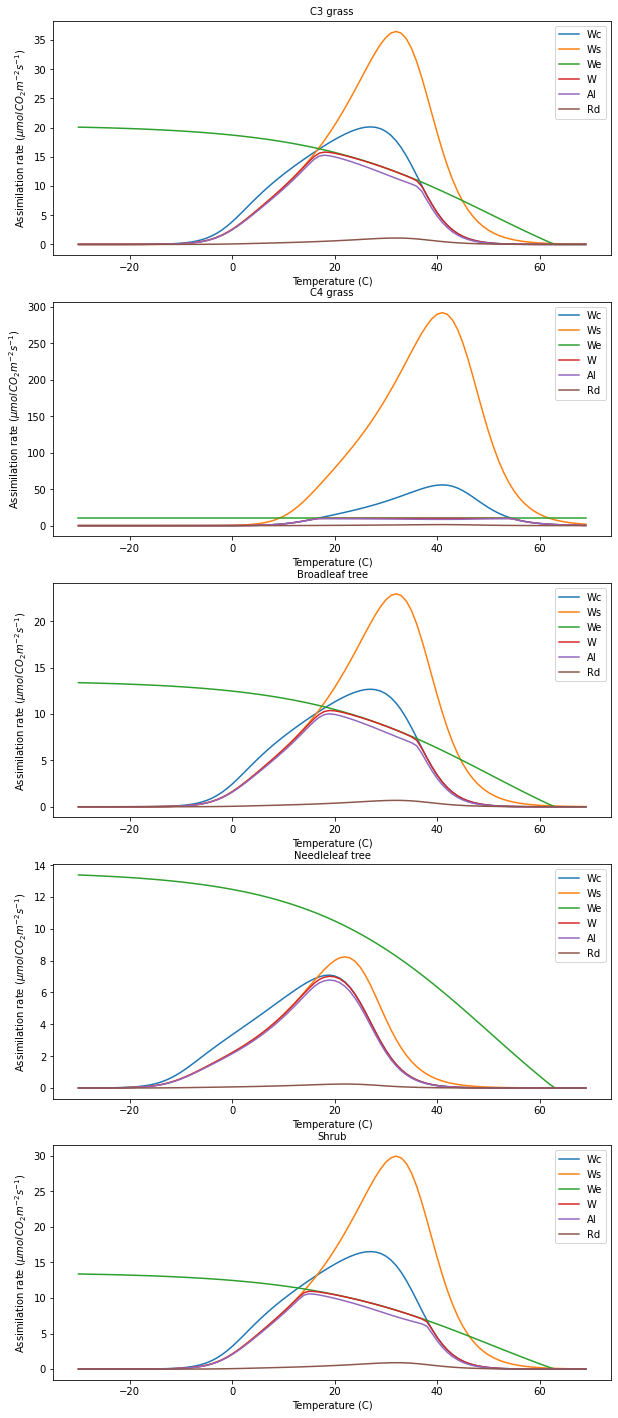

In [7]:
# list of all pfts
pfts = ['C3 grass','C4 grass',\
            'Broadleaf tree','Needleleaf tree','Shrub']

plotter = {
    'n_subplots' : len(pfts),  # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : None      # max value for y set
}

# store the data for each PFT in a dictionary
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(pft_type=pft,plotter=plotter)

We can access the data generated from the variable `photo`, e.g. for `We`:

In [8]:
print(output['C3 grass'].We * 1e6)
# or eg  maximum value using .max()
print(f"max We value for C3 grass {output['C3 grass'].We.max() * 1e6} umolCO2m-2s-1")

[20.07264114 20.05392673 20.03415539 20.01326894 19.99120619 19.96790277
 19.94329102 19.91729986 19.88985457 19.86087674 19.83028405 19.79799013
 19.76390443 19.72793204 19.68997355 19.64992489 19.60767719 19.56311662
 19.51612425 19.46657594 19.41434218 19.35928799 19.30127283 19.24015047
 19.17576897 19.10797059 19.03659177 18.96146314 18.88240955 18.79925011
 18.71179831 18.61986213 18.52324429 18.42174242 18.31514942 18.20325376
 18.08583995 17.96268901 17.83357906 17.69828597 17.55658409 17.40824711
 17.25304897 17.0907649  16.92117254 16.74405318 16.55919312 16.36638508
 16.16542976 15.9561375  15.73833    15.51184214 15.2765239  15.03224229
 14.77888341 14.51635445 14.24458577 13.96353297 13.67317884 13.37353537
 13.06464561 12.74658537 12.41946486 12.08343005 11.7386639  11.38538724
 11.02385948 10.65437893 10.27728282  9.89294692  9.50178488  9.10424706
  8.70081907  8.29201989  7.87839955  7.46053652  7.03903474  6.61452024
  6.18763765  5.75904628  5.32941618  4.89942389  4

### Experiment 1: What controls leaf-level photosynthesis?

#### Exercise

**Light-limiting assimilation**

We repeat Table 2 from [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html) for convenience:

![Clark et al., 2011: figure 2](images/jules-fig2.jpg)



From the data in this table and your understanding of the controls on photosynthesis in the model, answer the following questions and confirm your answer by running the model.

* which PFT has the highest values of `We`, and why?
* How does this change with increasing `ipar`?
* When ipar is the limiting factor, how does assimilation change when ipar increases by a factor of k?
* For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=200?
* For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=400?
* For C4 grasses, what are the limiting factors over the temperatures modelled? 

## leaf-scale photosynthesis

We will now use some appropriate weather data from our work in [03-Solar_Practical.ipynb](03-Solar_Practical.ipynb) to run the photosynthesis model for what should be typical conditions in space and time.

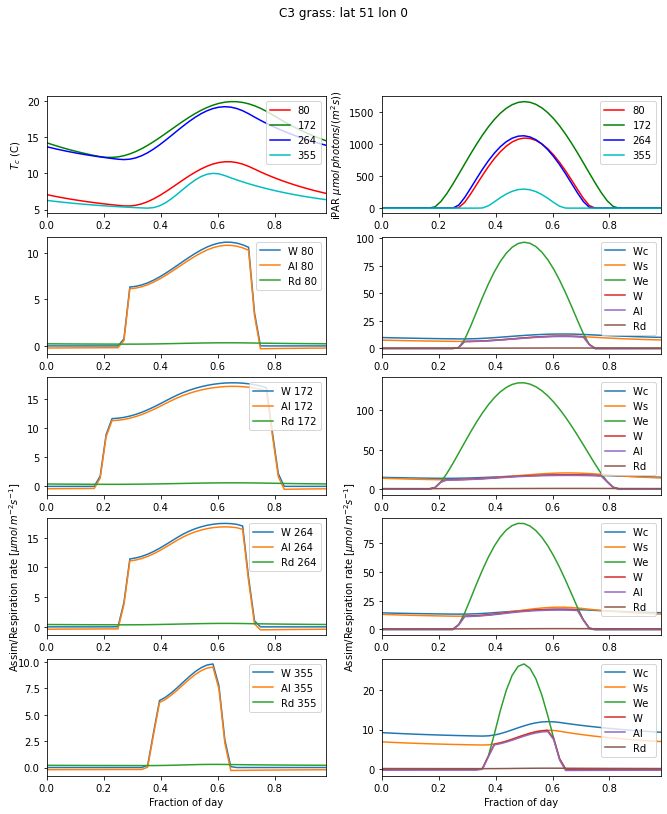

In [9]:
latitude = 51
longitude = 0

pft = "C3 grass"

year = 2019
doys = [80,172,264,355]

params = []
for i,doy in enumerate(doys):
    jd,ipar,Tc = radiation(latitude,longitude,doy,year=year)
    p = do_photosynthesis(n=len(ipar), pft_type=pft,Tc=Tc, \
                          ipar=ipar,co2_ppmv=390,\
                          x=ipar,plotter=None,\
                          Tnoise=0.0)[0]
    params.append((jd,ipar,Tc,p,doy))
    
# plotting code
day_plot(params,title=f'{pft}: lat {latitude} lon {longitude}')

This is an interesting figure as we can now use our theory to produce plots of leaf-level assimilation that look similar to those we will find in the literature. The plots are also interesting because they show us which factor is limiting in these cases. For C3 grass at latitude 51 degrees, we see that `Ws` and `Wc`, the transport rate and carboxylating rate and respectively, both functions of `Vcmax`, are the main limiting factors in the day time. These are strong functions of temperature, relative to the optimal temperature range for the given PFT. In the morning and evening, we see that assimilation becomes light-limited. The temperature range for C3 grass is 0 to 36 C, so the temperatures we see are well away from the extremes of toleration.
 
Looking at the left-hand column, we see that the maximum assimilation rate very much follows the `Tc` patterns: it is higher for days 172 and 264, and lower for 80 and 355. But another factor that is apparent is the daylength: this is considerably longer for day 80 than 355, so even if the maximum assimilation rate is similar, the carbon assimilation would likely be larger in the spring because of the longer daylength.

#### Exercise

* Explain the factors limiting Carbon assimilation for several PFTs, latitudes and time of year

You should relate your answer to the plots on assimilation as a function of temperature we examined earlier.

## Canopy scale assimilation

All of the above experimentation was just at the leaf level. We have essentially looked at responses to temperature and light intensity. Of course, in a ‘real’ canopy, there will be varying amounts of leaf area, so we have to consider how to scale up the leaf-level assimilation to the canopy scale.

Although there are various ways to scale from leaf-level assimilation to the canopy level, we have only implemented what is perhaps the simplest here. This is based on the assumption that there is an acclimatisation of leaf $N$ throughout the canopy (Sellers et al., 1992) giving:
$$
V_m = V_{m0} \overline{f(L)}
$$

where $\overline{f(L)}$ is the average fraction of absorbed PAR (as opposed to instantaneous) at leaf area index (LAI) $L$, $V_{m0}$ is the ‘maximum’ (top leaf) assimilation, and $V_m$ is the canopy-scale assimilation.

Assuming a homogeneous canopy, the canopy scale PAR use efficiency $\Pi$ is:

$$
\Pi = \int_{0}^{L} \overline{f(l)}\,dl. = \left[ \frac{1-e^{-\overline{k}L}}{\overline{k}} \right] = \frac{\overline{fAPAR}}{\overline{k}}
$$


where $\overline{fAPAR}$ is the (average) fraction of absorbed PAR by the canopy and $\overline{k}$ is an effective extinction coefficient:

$$
\overline{k} = \left[ \frac{G(\mu)}{\mu} \right] {(1-\omega_l)}^{\frac{1}{2}}
$$
with $\mu$ the cosine of the (time mean) solar zenith angle (a path length term), $G(\mu)$ the ‘Ross’ or ‘$G$’-function giving the average normalised leaf projection in the direction of the (time mean) incoming radiation, and $\omega_l$ is the leaf single scattering albedo (unity minus leaf absorption) in the PAR region (see Sellers et al., 1992 for more details).

Under these assumptions then, we can calculate canopy scale photosynthesis.

$$
GPP = A_l \frac{\overline{fAPAR}}{\overline{k}}.
$$


Suppose we have an amount of leaf carbon of 0.07 $kg\,C\,m^{−2}$ and a specific leaf density of 0.025 ($kg\,C\,m^{−2}$ per unit of LAI) that is constant throughout the canopy (giving a LAI of 0.07/0.025 = 2.8), and a $G$ gunction of 0.5 (e.g. a spherical leaf angle distribution). We can model this as:

In [10]:
def GPP(p,verbose=False):
    # now we want the canopy level response
    p.LAI = p.Lcarbon/p.sigmal

    # leaf single scattering albedo
    p.omega = 0.2
    p.G = 0.5
    p.mubar = np.mean(p.mu_)
    p.kbar = (p.G/p.mubar)*np.sqrt(1-p.omega)
    p.fapar = 1 - np.exp(-p.kbar * p.LAI)
    if verbose:
        print (f'doy {doy:03d} - mubar = {p.mubar:.2f}')
        print (f'doy {doy:03d} - kbar = {p.kbar:.2f}')
        print (f'doy {doy:03d} - fapar = {p.fapar.mean():.2f}')

    # kg C m-2 s-1: conversion factor from Clark et al. 2011
    p.PiG = 0.012 * (p.Al + p.Rd)* p.fapar / p.kbar
    return(p)

doy 080 - mubar = 0.20
doy 080 - kbar = 2.21
doy 080 - fapar = 1.00
doy 172 - mubar = 0.37
doy 172 - kbar = 1.22
doy 172 - fapar = 0.97
doy 264 - mubar = 0.21
doy 264 - kbar = 2.18
doy 264 - fapar = 1.00
doy 355 - mubar = 0.06
doy 355 - kbar = 7.86
doy 355 - fapar = 1.00


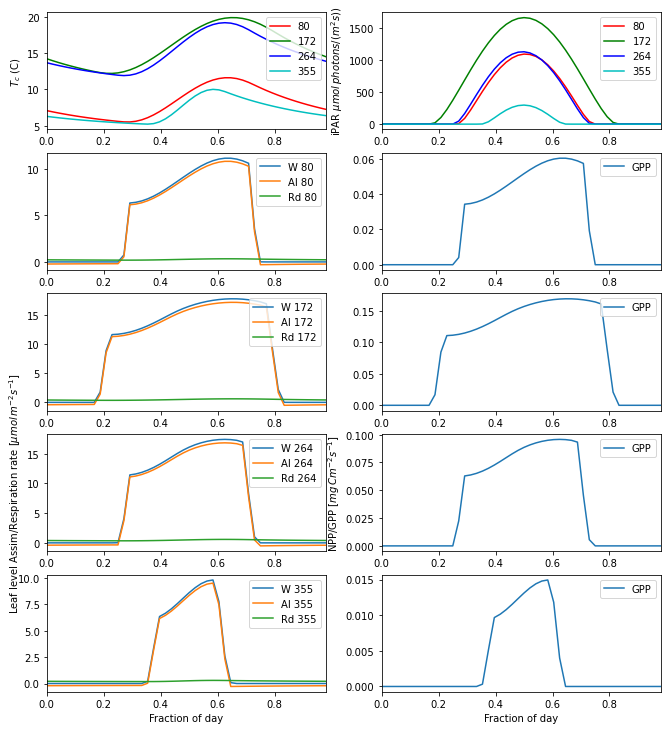

In [17]:
latitude = 51.
longitude = 0.0
pft = "C3 grass"
Tnoise = 0.0

year = 2019
doys = [80,172,264,355]

params = []
for i,doy in enumerate(doys):
    jd,ipar,Tc,mu = radiation(latitude,longitude,doy,\
                              domu=True,year=year)

    # run the leaf level model
    p = do_photosynthesis(n=len(ipar), pft_type=pft,Tc=Tc, \
                          ipar=ipar,co2_ppmv=390,\
                          x=ipar,plotter=None,\
                          Tnoise=Tnoise)[0]
    del p.Pi
    p.Lcarbon = 0.07 # kg C m-2
    p.mu_ =  mu
    p = GPP(p,verbose=True)
    params.append((jd,ipar,Tc,p,doy))

gpp_plot(params,info='',title=None)

The Net Ecosystem Productivity needs the plant respiration terms to be subtracted from the GPP. This is typically split into mainenance and growth respiration: $R_{pm}$ and $R_{pg}$ respectively. In Jules, $R_{pg}$ is assumed to be a fixed fraction of NPP:
$$
R_{p} = R_{pm} + R_{pg}
$$

$$
R_{pg} = r_g\Pi_{G}
$$


where $\Pi_{G}$ is the GPP (the canopy scale assimilation). In Jules, $r_g$ is set to 0.25 for all PFTs (Clark et al., 2011). Leaf maintenance respiration in Jules is the (moisture-modified, through a term $\beta$ that we have not dealt with here) canopy dark respiration (i.e. canopy-scaled). Root and stem respiration are set to depend on the nitrogen concentrations of the root and stem relative to the leaf nitrogen.

Since we have not introduced stem and root biomass yet, we will assume here that leaf, root and (respiring) stem biomass ($L$, $R$ and $S$ respectively) we will assume these terms equal for the moment, since we only require their relative amounts:
$$
R_{pm}=0.012\cdot R_{dc}\left[\beta+\frac{N_r + N_s}{N_l}\right]
$$
where:

$N_x$ is the Nitrogen concentration of biomass component $x$ and the factor 0.012 converts units (see Clark et al., 2011).

$$
N_l = n_m L
$$
$$
N_r = n_m R \mu_{rl}
$$
$$
N_s = n_m S \mu_{sl}
$$

where $\mu_{xl}$ is the relative Nitrogen concentartion of biomass component $x$ to leaf Nitrogen (assumed 1.0 here). $\beta=1$ for unstressed conditions. So:
$$
R_{pm}=0.012\cdot R_{dc}\left[\beta+\frac{R + S}{L}\right]
$$


In [29]:
def NPP(p):
    p = GPP(p,verbose=False)
    # NPP calculation
    p.rg = 0.25
    # scale Rd (respiration in the light) up to canopy here
    p.Rpm = 0.036 * p.Rd * p.fapar / p.kbar
    # Gpp from above, introducing beta
    p.PiG = 0.012*( p.Al - p.beta * p.Rd) * p.fapar / p.kbar
    # Grow respiration is a fraction of (GPP - maint resp)
    p.Rpg = p.rg * (p.PiG - p.Rpm)
    # ensure Rpg is non negative
    p.Rpg[p.Rpg < 0] = 0.
    # total respiration
    p.Rp = p.Rpm + p.Rpg
    # NPP: calculated as the difference
    p.Pi = p.PiG - p.Rp
    return p

Now plot this along with GPP:

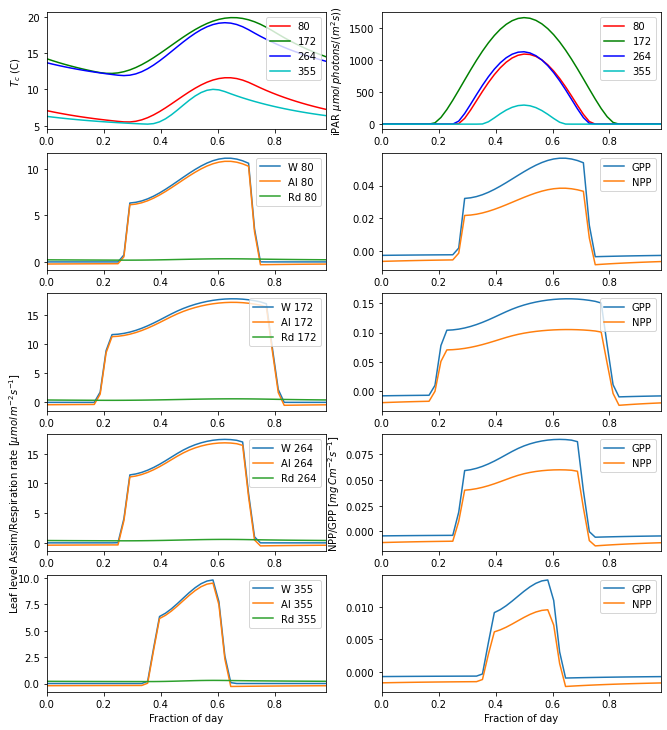

In [19]:
latitude = 51.
longitude = 0.0
pft = "C3 grass"
Tnoise=0.0

year = 2019
doys = [80,172,264,355]

params = []
for i,doy in enumerate(doys):
    jd,ipar,Tc,mu = radiation(latitude,longitude,doy,\
                              domu=True,year=year)

    # run the leaf level model
    p = do_photosynthesis(n=len(ipar), pft_type=pft,Tc=Tc, \
                          ipar=ipar,co2_ppmv=390,\
                          x=ipar,plotter=None,\
                          Tnoise=Tnoise)[0]
    
    # we need to store the cosine of the sun angle
    p.mu_ =  mu
    # specify leaf carbon
    p.Lcarbon = 0.07 # kg C m-2
    # now we want the canopy level response
    p = NPP(p)
    
    params.append((jd,ipar,Tc,p,doy))

gpp_plot(params,info='',title=None)

## Daily Carbon assimilation

We are now in a position to calculate the Carbon assimilation per day.

The values of GPP and NPP in the code are in units of $Kg\, C\, m^{-2} s^{-1}$ and simulated every 30 seconds, so to get the daily sum in units of $Kg\, C\, m^{-2} d^{-1}$ we can take the mean value, multiply by the number of seconds in a day:

In [20]:
def daily_PP(pft="C3 grass",Lcarbon=0.07,\
             latitude=51.,longitude=0.,year=2019,\
             Tnoise=0.0):
    '''
    Daily GPP and NPP
    
    Returns numpy arrays of:
        doys
        gpp
        npp
    
    Keywords:
        pft       : PFT name
                    default "C3 grass"
        Lcarbon   : leaf carbon (kg C m-2)
                    default 0.07
        latitude  : latitude (degrees)
                    default 51.0
        longitude : longitude (degrees)
                    default 0.0
        year      : year, default 2019
                    (2011-2019 allowed)
        Tnoise    : add Gaussian noise to Tc
                    to mimic variations
    
    '''
    doys = np.arange(1,366,dtype=int)
    gpp = np.zeros_like(doys).astype(float)
    npp = np.zeros_like(doys).astype(float)
    for i,doy in enumerate(doys):
        jd,ipar,Tc,mu = radiation(latitude,longitude,\
                                  int(doy),domu=True,year=year)
        # run the leaf level model
        p = do_photosynthesis(n=len(ipar), pft_type=pft,Tc=Tc,\
                              ipar=ipar,co2_ppmv=390,\
                              x=ipar,plotter=None,\
                              Tnoise=Tnoise)[0]
        # now we want the canopy level response
        p.mu_ =  mu
        p.Lcarbon = Lcarbon # kg C m-2
        p = NPP(p)
        nsec_in_day = 60 * 60 * 24
        gpp[i] = p.PiG.mean() * nsec_in_day
        npp[i] = p.Pi.mean() * nsec_in_day
    return doys,gpp,npp


In [21]:
latitude = 40.
longitude = 116.
year = 2019
pft = "C3 grass"
Tnoise = 0.0

doys,gpp,npp = daily_PP(pft=pft,year=year,Tnoise=Tnoise,\
                        latitude=latitude,longitude=longitude)

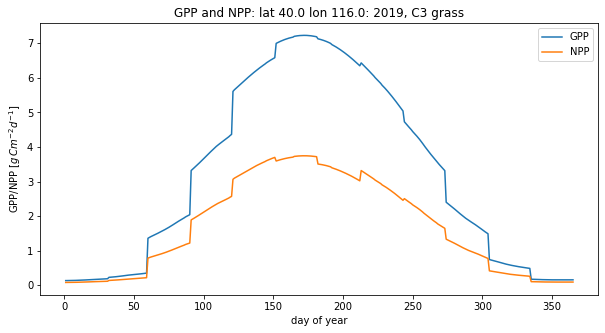

In [22]:
plt.figure(figsize=(10,5))
plt.title(f'GPP and NPP: lat {latitude:.1f} lon {longitude:.1f}:'+\
         f' {year}, {pft}')
plt.plot(doys,gpp*1e3,label='GPP')
plt.plot(doys,npp*1e3,label='NPP')
plt.ylabel('GPP/NPP $[g\,C m^{-2}d^{-1}]$')
plt.xlabel('day of year')
_=plt.legend()

This looks like a reasonable form for the plot: at 40 degrees latitude, we get a strong variation from winter to summer. 

The 'jagged' shape of the lines arises from assuming the same value of temperature for each month. You can reduce the impact of that by setting some positive value to `Tnoise` if you like. The value you set specifies the standard deviation of the noise added to the temperature. If you do, then you might want to examine the impact of the noise (daily variation) on the mean NPP/GPP. Why might (zero mean) random noise (variation) on temperature be expected to affect the average NPP/GPP?

Since we have calcualted NPP and GPP, we can integrate them over the year. We can report the summation in units of $g\, C\, m^{-2} y^{-1}$ or equivalently $t\, C\, km^{-2} y^{-1}$ with $t$ metric tons (1000 kg).

Sometimes, we will see NPP reported in units of $t\, C\, ha^{-1} y^{-1}$. Since $1\, ha = 0.01 km^2$, this involves a scaling factor of 0.01:

In [23]:
print('mean NPP = {:.4f} {:s}'.format(np.mean(npp) * 1e3,
        'g C m-2 day-1'))
print('mean GPP = {:.4f} {:s}'.format(np.mean(gpp) * 1e3,
        'g C m-2 day-1'))
integral = np.sum(npp) * 1e3 # g C m-2 yr-1
print (f"NPP = {integral * 0.01:.2f} t C/ha/yr")

mean NPP = 1.7052 g C m-2 day-1
mean GPP = 3.2309 g C m-2 day-1
NPP = 6.22 t C/ha/yr


#### Exercise

From the illustration above, we get an NPP for C3 grass for a latitude 40N of 6.22 t C/ha/yr. 

* Check in the literature that this is a reasonable value for NPP
* Explore how the annual NPP compares for different biomes and latitudes

(NB No model answers given for this section -- you need to follow it up yourself)

## Summary

NPP is a key concept in terrestrial carbon dynamics. It expresses the 'raw' inputs of carbon (from the atmosphere) to vegetation. It is driven by solar radiation and so, not surprisingly broadly follows global patterns of radiation, but it is also limited by temperature, water, nutrients, and an opportunity to grow.

We have used all of the theory we have learned about in the lectures to develop a model of NPP that we can apply to different biomes (PFTs), locations and times. The model we have here is intentionally limited and slightly simplified for illustration, but is in essence the same as you will find in any DGVM. We have seen that the emphasis here has been on leaf-level carbon exchange, with a somewhat simplistic scaling of process from the leaf to the canopy, but that is the state of the art in this area. We have also seen that the PFT approach allows us to draw general conclusions about primary production and the impact of climate on this, but even in this case, there are quite a number of internal parameters that are assumed *known*. We have not, in this work, included any idea of these parameters being uncertain or poorly constrained, but that is most surely the case. How well this sort of modelling relates to reality has been the subject of a large number of studies and comparisons with measurement, and it is only through such comparisons that we learn about any deficiencies in our models. 

One of the simplifications made in the modelling here is that the leaf carbon (hence the leaf area index, LAI) is specified: even though we calculate the carbon input, we do not (in this model) go the final stage of allocating this carbon to plant organs. One reason for that is that we then need to consider phenology, which is beyond the scope of this practical. When you are thinking through what you have learned from this practical though, you should have the ideas to hand from the lecture materials to be able to think through how we might implement plant growth and senescence in a model of this nature: once you have that, you have most of the ingredients of your own DGVM!

## Extra Advanced Tasks

Only attempt these if you really want to explore them. 

First update some files. Use a jupyter-hub terminal, and navigate to:

`geog0133-main/docs/notebooks_lab`

Then update this notebook using:

`wget https://github.com/UCL-EO/geog0133/raw/main/docs/notebooks_lab/011_Photosynthesis_Modelling_Practical.ipynb`

The notebook may have downloaded as a copy with an extension `011_Photosynthesis_Modelling_Practical.ipynb.1`. Use a `mv` command to change its name. If you've previously modified this notebook before, you may wish for another copy.

You may need to updat esome code within the `geog0133` subdirectory. Use:

`wget https://github.com/UCL-EO/geog0133/raw/main/docs/notebooks_lab/geog0113/cru.py`

followed by:

`mv cru.py geog0133/.`

The modelling activities in the practical rely on a global dataset of temperature and cloud cover. We add to this a model of incoming radiation. These data are then used as input variables. The input data for a given doy and year can be plotted below. Can you make a similar map for GPP/NPP?

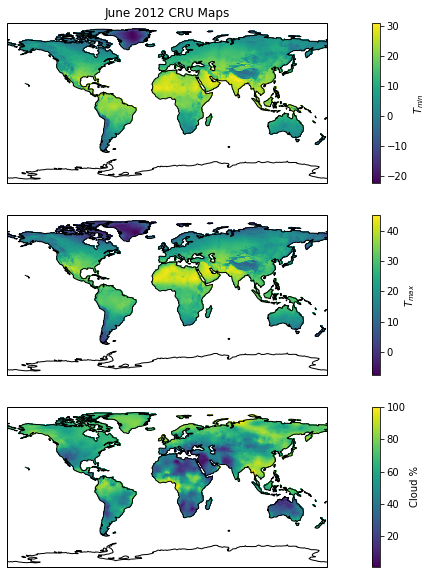

In [87]:
from geog0133.cru import getCRU_lonlat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.vectorized

lons,lats = getCRU_lonlat()

Tlons,Tlats = np.meshgrid(lons,lats)
ocean = cfeature.OCEAN
allocean = list(ocean.geometries())
mask = np.sum([shapely.vectorized.contains(c, Tlons, Tlats) 
                       for c in allocean],axis=0)
ocean_mask = np.ones_like(mask,dtype=float)
ocean_mask[mask==1] = np.nan


year = 2012
doy = 135

datetime_object = datetime(year,1,1)+timedelta(doy-1)

month = datetime_object.month

data_map = getCRU(year=2012,month=[month],longitude='all',latitude='all')

cru_vars = ['tmn','tmx','cld']
cru_labs = [r'$T_{min}$',r'$T_{max}$',r'Cloud %']


f = plt.figure(figsize=(16,10))

for pn,(var,lab) in enumerate(zip(cru_vars,cru_labs)):
    ax = f.add_subplot(3,1,pn+1,projection=ccrs.PlateCarree())
    if pn == 0:
        ax.set_title(datetime(year,month+1,1).strftime('%B %Y')+' CRU Maps')
    s = ax.pcolormesh(lons,lats,data_map[var][0]*ocean_mask)
    ax.add_feature(cfeature.COASTLINE)
    sax = plt.colorbar(s)
    sax.set_label(lab)
plt.show()

We can try to fill the map using a loop, a working example is below, though this has issues.

In [85]:
#### remembering the doy and year from above we loop over the map
#### (this is inefficient use of python, but it is the most usable and understandable)
#### the loop only goes up to 50 in the lon index, this is slow enough, you can alter this and wait
Tnoise = 0.0
pft="C3 grass"
Lcarbon=0.07

c=0
r=0
### first an empty array
array_gpp = np.zeros_like(data_map['tmx'][0]) * np.nan
array_npp = np.zeros_like(data_map['tmx'][0]) * np.nan
for l1,lat in enumerate(lats[:]):
    for l2,lon in enumerate(lons[:60]):
        ### ignore the ocean
        if np.isnan(ocean_mask[l1,l2]):
            continue
        #### don't do anything if no data
        if data_map['tmx'].mask[0,l1,l2]: 
            continue
        jd,ipar,Tc,mu = radiation(lat,lon,\
                                  int(doy),domu=True,year=year)
        # run the leaf level model
        p = do_photosynthesis(n=len(ipar), pft_type=pft,Tc=Tc,\
                              ipar=ipar,co2_ppmv=390,\
                              x=ipar,plotter=None,\
                              Tnoise=Tnoise)[0]
        # now we want the canopy level response
        p.mu_ =  mu
        p.Lcarbon = Lcarbon # kg C m-2
        p = NPP(p)
        nsec_in_day = 60 * 60 * 24
        array_gpp[l1,l2] = p.PiG.mean() * nsec_in_day
        array_npp[l1,l2] = p.Pi.mean() * nsec_in_day


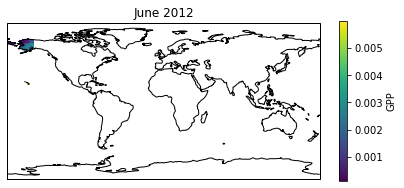

In [88]:
#### plotting the results of the above loop
f = plt.figure(figsize=(7,10))

ax = f.add_subplot(3,1,pn+1,projection=ccrs.PlateCarree())
ax.set_title(datetime(year,month+1,1).strftime('%B %Y'))
s = ax.pcolormesh(lons,lats,array_gpp)
ax.add_feature(cfeature.COASTLINE)
sax = plt.colorbar(s)
sax.set_label('GPP')
plt.show()

Here are some coding challenges you may wish to explore:

* Sit and wait for the whole map to process and visualise it (not recommended).

* Find a smaller area to plot. Use `ax.set_extent([lon_min,lon_max,lat_min,lat_max])` to zoom in the projection. Can you adjust the loop above to only process the code in this area? (HINT `if lon>lon_min and lon<lon_max)`)

* Reduce the size of the problem. Iterate over every 10 grid cells in each direction, fill these cells with the value from the centre.

* If you really know how to use your python and numpy efficiently, and you REALLY want these detailed global maps of NPP/GPP, look in the geog0133 folder by this notebook. Here are all the functions the we use in this practical. Can you modify them to take in the whole CRU maps as arrays? This is the efficient way to use numpy.

I can advise on these extra tasks, but they are extra material for those who want, so you are somewhat on your own!